Load the libraries

In [15]:

import tensorflow as tf 
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import funcs as ff #utilities leo
from VAE import VAE #classe Variational AutoEncoder leo

tf.random.set_seed(42)
autotune = tf.data.experimental.AUTOTUNE
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pickle

# Data Loading and preprocessing

In [16]:


'''
DIRECTORIES
'''
cwd = '/Volumes/Seagate Backup Plus Drive/EXPERIMENTS' #os.getcwd()

serie_dir = os.path.join(cwd, 'Embeddings')
if not os.path.isdir(serie_dir):
    os.makedirs(serie_dir)

exp_dir = os.path.join(serie_dir, 'DenseNet201-vae100-finetuning')
if not os.path.isdir(exp_dir):
    os.makedirs(exp_dir)

last_ckpt = os.path.join(exp_dir, 'last_model')
if not os.path.isdir(last_ckpt):
  os.mkdir(last_ckpt)

datasets_dir = '/Volumes/Seagate Backup Plus Drive/datasets'

output_dir = os.path.join(datasets_dir, 'embeddings')
if not os.path.isdir(output_dir):
    os.mkdir(output_dir)

print('cwd : ', cwd)
print('serie dir : ', serie_dir)
print('exp_dir : ', exp_dir)
print('last ckpt dir : ', last_ckpt)

cwd :  /Volumes/Seagate Backup Plus Drive/EXPERIMENTS
serie dir :  /Volumes/Seagate Backup Plus Drive/EXPERIMENTS/Embeddings
exp_dir :  /Volumes/Seagate Backup Plus Drive/EXPERIMENTS/Embeddings/DenseNet201-vae100-finetuning
last ckpt dir :  /Volumes/Seagate Backup Plus Drive/EXPERIMENTS/Embeddings/DenseNet201-vae100-finetuning/last_model


In [17]:
### dataset con val e test (val per training di embeddings) quello originale 12
label_length=14
z_dimension = 100

def record_parser(example):
    example_fmt = {'label': tf.io.FixedLenFeature([label_length], tf.float32),
        'z_mean': tf.io.FixedLenFeature([z_dimension], tf.float32),
        'z_logsigma': tf.io.FixedLenFeature([z_dimension], tf.float32)
    }
    parsed = tf.io.parse_single_example(example, example_fmt)
    
    return parsed["label"], parsed["z_mean"], parsed["z_logsigma"]

def make_tfDataset(full_path, batch_size=1):
    dataset = tf.data.TFRecordDataset(full_path)
    parsed_dataset = dataset.map(record_parser,num_parallel_calls = autotune).batch(batch_size, drop_remainder=True).prefetch(1)
    print(parsed_dataset)
    for label, zm, zls in parsed_dataset.take(1):
        print(label)
        print(zm)
        print(zls)
    return parsed_dataset
base_path = '/Volumes/Seagate Backup Plus Drive/datasets/embeddings'

valid_ds_path = os.path.join(base_path, 'densenet201-100-val')
test_ds_path = os.path.join(base_path, 'densenet201-100-test')
val_dataset=make_tfDataset(valid_ds_path)
test_dataset=make_tfDataset(test_ds_path)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
<PrefetchDataset shapes: ((1, 14), (1, 100), (1, 100)), types: (tf.float32, tf.float32, tf.float32)>
tf.Tensor([[0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.]], shape=(1, 14), dtype=float32)
tf.Tensor(
[[ 0.         2.2481039  5.571806   0.         0.         6.169139
   0.         0.         0.         0.         0.         0.
   4.1381936  2.3966656  0.         0.         6.961697   0.
   0.       

In [18]:
chexpert_labels = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
                'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
target_labels = ['Cardiomegaly','Edema','Consolidation','Atelectasis','Pleural Effusion']
label_mask=[chexpert_labels[i] in target_labels for i, _ in enumerate(chexpert_labels)]

In [19]:
dummy_labels = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
                'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']

target_labels = ['Cardiomegaly','Edema','Consolidation','Atelectasis','Pleural Effusion']
hum_labels=[ "Pleura", "Device", "PNX", "Cardiac", "Lung", "Bone", "Normal"]
titles=["dense121", "dense169", "vgg19", "xception", "dense201", "vgg16", "inceptionresnetv2"]
#fig, c_ax = plt.subplots(2,3, figsize = (15, 10))

# Stacking

In [20]:
def split_tfrecord_ds(ds):
    l = []
    zm = []
    zls = []
    for label, z_mean, z_logsigma in ds:
        l.append(label.numpy())
        zm.append(z_mean.numpy())
        zls.append(z_logsigma.numpy())

    x = np.array(zm)
    y = np.array(l)

    return x, y

x, y = split_tfrecord_ds(val_dataset.unbatch())

# Embedding

In [21]:
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV,RepeatedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier
from scipy.stats import entropy
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier


### Grid-search CV for tuning

In [22]:
### ML models
GRID_SEARCH = False

if GRID_SEARCH:
    random_seed=0
    n_estimators=100
    def finetune_cv(data, labels, param_grid, model):
      cv=RepeatedKFold(n_splits=5, n_repeats=3, random_state=0)
      grid = GridSearchCV(model, param_grid, cv=cv, verbose=1, scoring="roc_auc", n_jobs=-1)
      grid.fit(data,labels)
      print("best estimator:")
      print(grid.best_estimator_)
      best_model = grid.best_estimator_
      return best_model
    # Number of trees in random forest
    param_grid_xrt = {'n_estimators': [10, 50, 100],
                     'criterion': ["gini", "entropy"],
                  'max_depth': [2,5,10, None],
                  'min_samples_split': [2, 5, 10],
                  'min_samples_leaf': [1, 2, 4],
                  'random_state': [0],
                  'n_jobs':[-1]}
    param_grid_rf = {'n_estimators': [200, 500, 1000, 1500],
                     'criterion': ["gini", "entropy"],
                  'max_depth': [9, 10, 11],
                  'min_samples_split': [10, 12, 15],
                  'min_samples_leaf': [4, 7, 10],
                  'bootstrap': [True, False],
                  'random_state': [0]}

    param_grid_KNN = {'n_neighbors': [10, 13, 15, 20],
                      'p': [1,2],
                      'n_jobs':[-1]}

    start_time = time.time()
    ML_models = {'Decision Tree':DecisionTreeClassifier(max_depth=10,
                                                            random_state=random_seed),
                        'Random Forest':finetune_cv(x, y.astype(int), param_grid_rf, RandomForestClassifier()),
                        'Extremely Randomized Trees':finetune_cv(x, y.astype(int), param_grid_xrt, ExtraTreesClassifier()),
                        'KNN': finetune_cv(x, y.astype(int), param_grid_KNN, KNeighborsClassifier())
                    }
    print('time for grid search : {}'.format(time.time()-start_time))
else:
    ML_models={'Decision Tree': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                            max_depth=10, max_features=None, max_leaf_nodes=None,
                            min_impurity_decrease=0.0, min_impurity_split=None,
                            min_samples_leaf=1, min_samples_split=2,
                            min_weight_fraction_leaf=0.0,
                            random_state=0, splitter='best'),
     'Extremely Randomized Trees': ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                          criterion='entropy', max_depth=5, max_features='auto',
                          max_leaf_nodes=None, max_samples=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=2, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
                          oob_score=False, random_state=0, verbose=0,
                          warm_start=False),
     'KNN': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                          metric_params=None, n_jobs=-1, n_neighbors=20, p=1,
                          weights='uniform'),
     'Random Forest': RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                            criterion='gini', max_depth=10, max_features='auto',
                            max_leaf_nodes=None, max_samples=None,
                            min_impurity_decrease=0.0, min_impurity_split=None,
                            min_samples_leaf=4, min_samples_split=12,
                            min_weight_fraction_leaf=0.0, n_estimators=1500,
                            n_jobs=None, oob_score=False, random_state=0, verbose=0,
                            warm_start=False)}

In [23]:
t_x, t_y = split_tfrecord_ds(test_dataset.unbatch())

rf = ML_models['Random Forest']
rf.fit(x, y.astype(int))
rf_pred = np.array(rf.predict_proba(t_x))[:,:,1].T

xrt = ML_models['Extremely Randomized Trees']
xrt.fit(x, y.astype(int))
xrt_pred = np.array(xrt.predict_proba(t_x))[:,:,1].T

knn = ML_models['KNN']
knn.fit(x, y.astype(int))
knn_pred = np.array(knn.predict_proba(t_x))[:,:,1].T

dt = ML_models['Decision Tree']
dt.fit(x, y.astype(int))
dt_pred = np.array(dt.predict_proba(t_x))[:,:,1].T


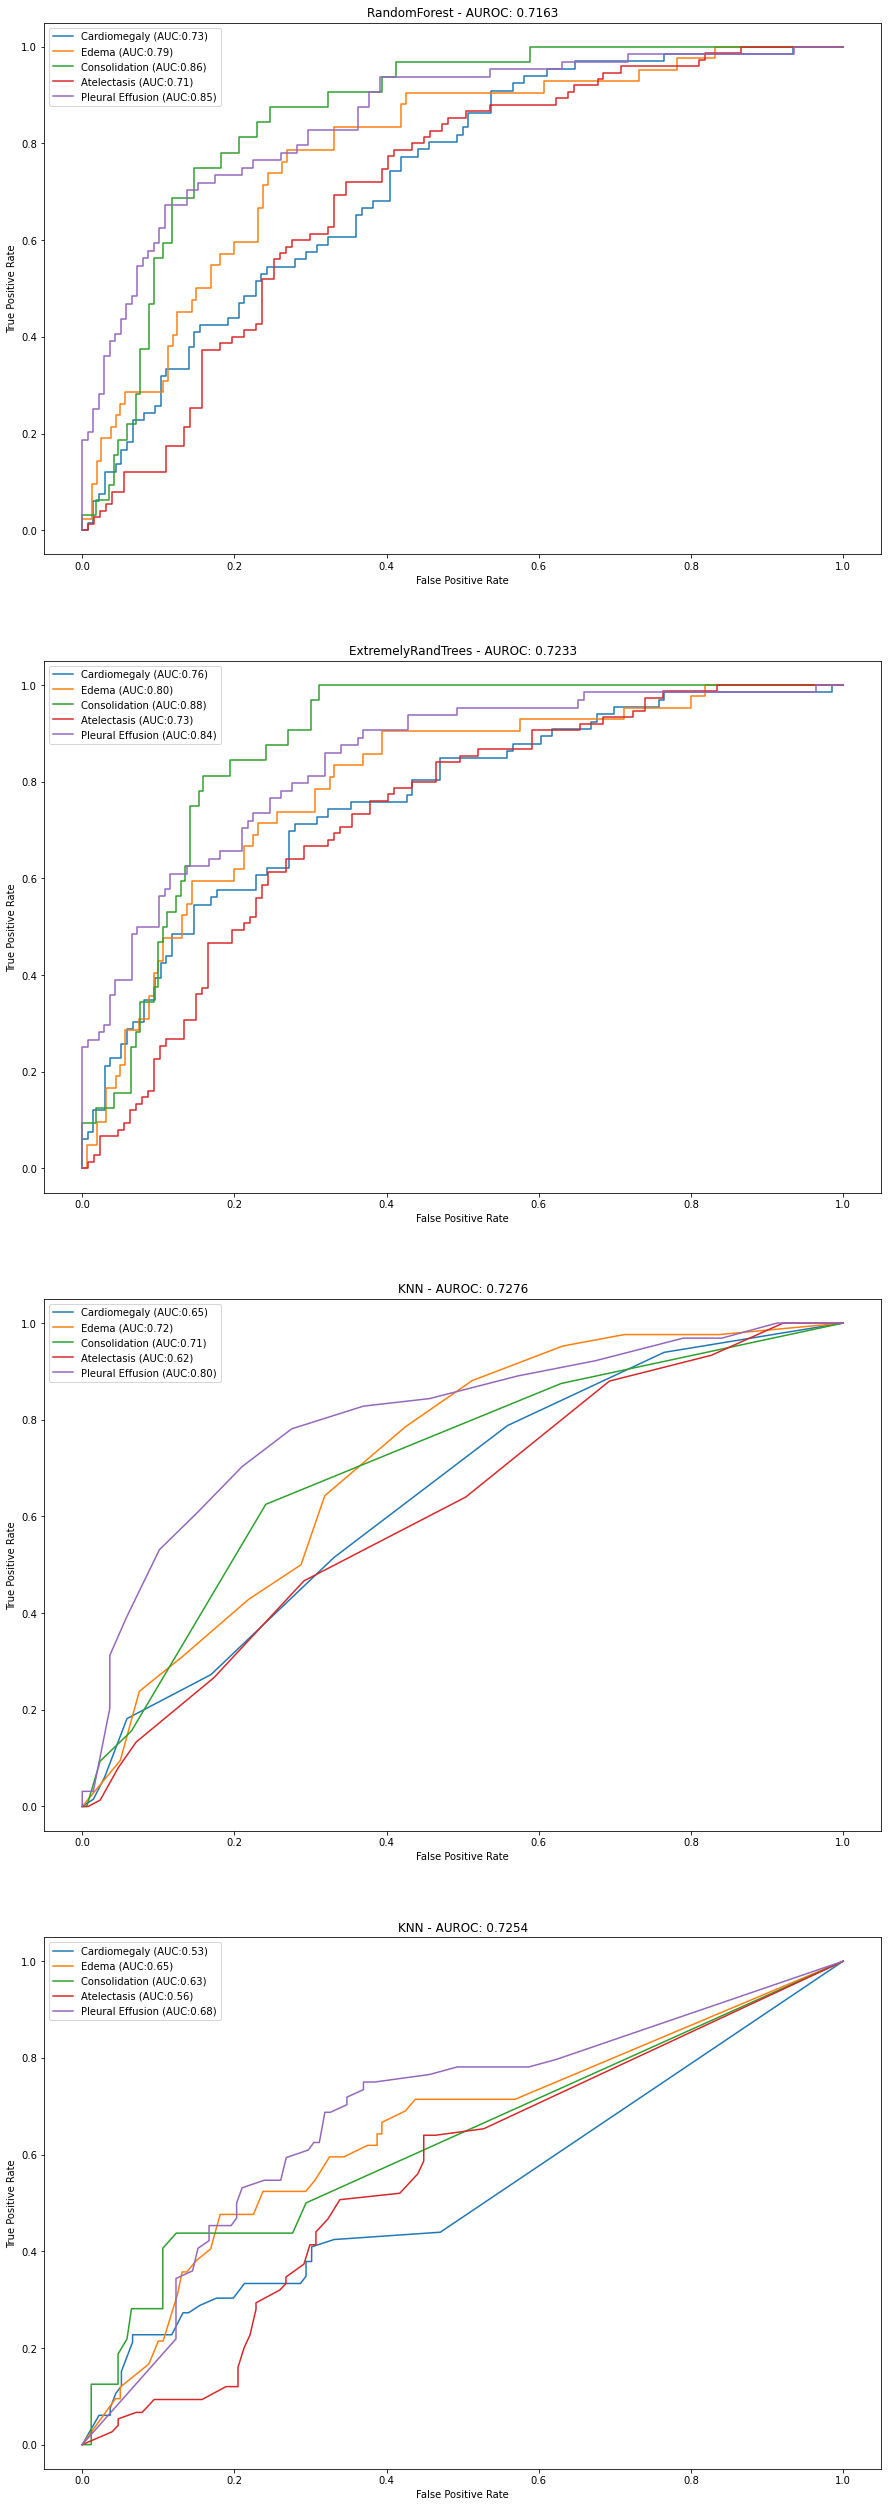

In [24]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

aurocs = []
fig, ax = plt.subplots(4, figsize = (15, 45))
for i, label in enumerate(chexpert_labels):
    if label_mask[i]:
        #Random forest plot
        fpr, tpr, thresholds = roc_curve(t_y[:,i].astype(int), rf_pred[:,i])
        ax[0].plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (label, auc(fpr, tpr)))
        aurocs.append(auc(fpr, tpr))
        ax[0].legend()
        ax[0].set_xlabel('False Positive Rate')
        ax[0].set_ylabel('True Positive Rate')
        ax[0].set_title('RandomForest - AUROC: {:0.4f}'.format(np.mean(aurocs)))
        #plt.savefig(exp_dir+"/Auroc-RF")

        #Extremely randomized tree
        fpr, tpr, thresholds = roc_curve(t_y[:,i].astype(int), xrt_pred[:,i])
        ax[1].plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (label, auc(fpr, tpr)))
        aurocs.append(auc(fpr, tpr))
        ax[1].legend()
        ax[1].set_xlabel('False Positive Rate')
        ax[1].set_ylabel('True Positive Rate')
        ax[1].set_title('ExtremelyRandTrees - AUROC: {:0.4f}'.format(np.mean(aurocs)))
        #plt.savefig(exp_dir+"/Auroc-XRT")

        #KNN
        fpr, tpr, thresholds = roc_curve(t_y[:,i].astype(int), knn_pred[:,i])
        ax[2].plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (label, auc(fpr, tpr)))
        aurocs.append(auc(fpr, tpr))
        ax[2].legend()
        ax[2].set_xlabel('False Positive Rate')
        ax[2].set_ylabel('True Positive Rate')
        ax[2].set_title('KNN - AUROC: {:0.4f}'.format(np.mean(aurocs)))

        #Decision Tree
        fpr, tpr, thresholds = roc_curve(t_y[:,i].astype(int), dt_pred[:,i])
        ax[3].plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (label, auc(fpr, tpr)))
        aurocs.append(auc(fpr, tpr))
        ax[3].legend()
        ax[3].set_xlabel('False Positive Rate')
        ax[3].set_ylabel('True Positive Rate')
        ax[3].set_title('KNN - AUROC: {:0.4f}'.format(np.mean(aurocs)))
    plt.savefig(exp_dir+"/Auroc-multiple")